
# Problem set 5: Solow Model

**What you’ll practice**
- Writing small, testable functions.  
- Plotting steady states and transition dynamics.  
- Building a widget-based slider plot for the steady state figure.  
- Extending the **simulator** from lecture 9 to incorporate growth in technology and population.



In [2]:

# Convenience setup (safe to run)
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from types import SimpleNamespace


**Table of contents**<a id='toc0_'></a>    
- 1. [Recap: Baseline Solow (no growth)](#toc1_)    
- 2. [Add technology growth \(g\)](#toc2_)    
  - 2.1. [Compute steady-state Capital](#toc2_1_)    
  - 2.2. [Plot the steady-state diagram with technology growth ($g>0$, $n=0$)](#toc2_2_)    
- 3. [Add **population growth** ($n>0$) with **technology growth** fixed at $g>0$](#toc3_)    
  - 3.1. [Implement the steady-state function with $g>0$ and $n\ge 0$](#toc3_1_)    
  - 3.2. [Plot the steady state diagram with population growth](#toc3_2_)    
- 4. [Static steady-state comparison](#toc4_)    
- 5. [Simulator with \(g\) and \(n\)](#toc5_)    
  - 5.1. [Extend the Simulator](#toc5_1_)    
  - 5.2. [Halving population growth under $g>0$](#toc5_2_)    
  - 5.3. [Savings rate rises by 20%](#toc5_3_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->


## 1. <a id='toc1_'></a>[Recap: Baseline Solow (no growth)](#toc0_)

We work with Cobb–Douglas production in intensive form:
$ y = f(k) = k^{\alpha}, \qquad 0<\alpha<1. $

Law of motion for capital per worker (no growth):
$ k_{t+1} = s f(k_t) + (1-\delta)k_t. $
Steady state solves
$ s k^{\alpha} = \delta k. $


In [3]:
# === Baseline parameters (edit these for experiments) ===
params = {
    'alpha': 0.33,   # capital share
    's':     0.25,   # savings rate
    'delta': 0.06,   # depreciation
}

print(f'Baseline parameters from dictionary: {params}')

# We can also create a SimpleNamespace from the dictionary for easier access
parameters = SimpleNamespace(**params)
print(f'Baseline parameters from SimpleNamespace: {parameters}')

# And access the simplenamespace attributes using dot notation::
print(f'Alpha: {parameters.alpha}')


# We can also create an empty namespace and add attributes later
more_params = SimpleNamespace()
more_params.delta = 0.06
print(f'Delta: {more_params.delta}')


Baseline parameters from dictionary: {'alpha': 0.33, 's': 0.25, 'delta': 0.06}
Baseline parameters from SimpleNamespace: namespace(alpha=0.33, s=0.25, delta=0.06)
Alpha: 0.33
Delta: 0.06


In [4]:
# === Core functions for the Solow model (per worker) ===

def f(k, alpha):
    return np.power(k, alpha)

def fprime(k, alpha):
    return alpha * np.power(k, alpha-1)

def k_star_no_growth(alpha, s, delta):
    return np.power(s / delta, 1.0 / (1.0 - alpha))
# np.power is used for element-wise exponentiation
# sets left of parentheses to the power of right of parentheses

# quick test
print("k* (no growth), alpha=1/3, s=0.2, delta=0.08 ->", k_star_no_growth(1/3, 0.2, 0.08))


k* (no growth), alpha=1/3, s=0.2, delta=0.08 -> 3.952847075210473


In [5]:
### Alternative formulation with dictionary and simplenamespace

def k_star_no_growth_dict(params):
    # unpack parameters from dictionary
    alpha = params['alpha']
    s = params['s']
    delta = params['delta']
    return np.power(s / delta, 1.0 / (1.0 - alpha))

print(f"k* (no growth), alpha={params['alpha']}, s={params['s']}, delta={params['delta']} ->", k_star_no_growth_dict(params))

def k_star_no_growth_ns(params):
    # unpack parameters from SimpleNamespace
    alpha = params.alpha
    s = params.s
    delta = params.delta
    return np.power(s / delta, 1.0 / (1.0 - alpha))

# alternative formatting
print("k* (no growth), alpha={}, s={}, delta={} ->".format(parameters.alpha, parameters.s, parameters.delta), k_star_no_growth_ns(parameters))


k* (no growth), alpha=0.33, s=0.25, delta=0.06 -> 8.415072232654062
k* (no growth), alpha=0.33, s=0.25, delta=0.06 -> 8.415072232654062


In [6]:
# reformulate the last two core functions using SimpleNamespace
# I will use namespace for the rest of the notebook

def f_ns(k, params):
    return np.power(k, params.alpha)

def fprime_ns(k, params):
    return params.alpha * np.power(k, params.alpha-1)


## 2. <a id='toc2_'></a>[Add technology growth \(g\)](#toc0_)

Let technology grow at gross rate \(1+g\) so that \(A_{t+1}=(1+g)A_t\). Define variables **per effective worker**:
$ k \equiv \frac{K}{AL}, \qquad y \equiv \frac{Y}{AL}. $

The discrete-time law of motion becomes
$
k_{t+1} \;=\; \frac{s f(k_t) + (1-\delta)k_t}{1+g}.
$
The steady state \(k^*\) solves
$
s f(k^*) \;=\; \underbrace{\big[(1+g) - (1-\delta)\big]}_{\displaystyle \delta + g}\, k^*.
$

For Cobb–Douglas $f(k)=k^\alpha$, $k^* = \left(\frac{s}{\delta + g}\right)^{\tfrac{1}{1-\alpha}}$.


### 2.1. <a id='toc2_1_'></a>[Compute steady-state Capital](#toc0_)

**Task:** Define a function `k_star_with_g(alpha, s, delta, g)` that computes the steady state capital  per-effective-worker cwith technology growth g (n=0). Print the chosen parameter values and the resulting $k^*$.

In [7]:
# add parameter, g, for growth rate
parameters.g = 0.02  # growth rate

def k_star_with_g(params):
    # unpack parameters from SimpleNamespace
    g = params.g
    alpha = params.alpha
    s = params.s
    delta = params.delta
    return np.power(s / (delta + g), 1.0 / (1.0 - alpha))

print(f'k* (with growth), alpha={parameters.alpha}, s={parameters.s}, '
      f'delta={parameters.delta}, g={parameters.g} ->', k_star_with_g(parameters))

k* (with growth), alpha=0.33, s=0.25, delta=0.06, g=0.02 -> 5.477496666261667


### 2.2. <a id='toc2_2_'></a>[Plot the steady-state diagram with technology growth ($g>0$, $n=0$)](#toc0_)

**Task.** Plot the Solow steady state **per effective worker** when technology grows at rate $g$ (population fixed). Show the two curves on one figure and mark $k^*$.

**Theory recap**
- Intensive production: $f(k)=k^{\alpha}$, with $0<\alpha<1$.
- Law of motion (per effective worker): $k_{t+1}=\dfrac{s f(k_t)+(1-\delta)k_t}{1+g}$.
- Break-even line: $(\delta+g)\,k$.

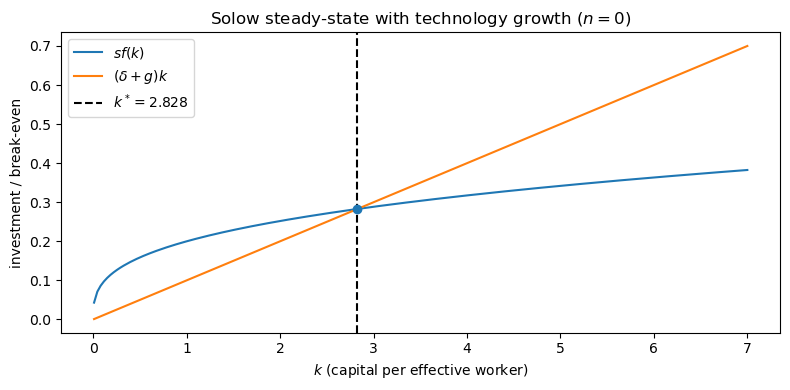

k* (g>0), alpha=0.33, s=0.20, delta=0.08, g=0.02 -> 2.83
k* (no growth), alpha=0.33, s=0.20, delta=0.08 -> 3.95


In [8]:
# change parameter delta to match solution
parameters.alpha = 1/3
parameters.delta = 0.08
parameters.s = 0.2

# create an array of k values for plotting
k_values = np.linspace(0.01, 7.0, 200)

# compute functions on plot
saving_values = parameters.s * f_ns(k_values,parameters)
break_down_values = (parameters.delta + parameters.g) * k_values
steady_state_k = k_star_with_g(parameters)


# plot the functions
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(1,1,1)
ax.plot(k_values, saving_values, label='$sf(k)$') # savings/blue line
ax.plot(k_values, break_down_values, label=r'$(\delta + g)k$') # break-down/orange line
# using raw string ('r') for LaTeX formatting, so backslash('\') is not an escape character
ax.axvline(steady_state_k, color='black', linestyle='--', label=f'$k^*={steady_state_k:.3f}$') # line marking k*

# Cosmetics
ax.scatter(steady_state_k, parameters.s * f_ns(steady_state_k,parameters), zorder=10) # steady-state point
ax.set_xlabel('$k$ (capital per effective worker)')
ax.set_ylabel('investment / break-even')
ax.set_title('Solow steady-state with technology growth $(n=0)$')
ax.legend()
fig.tight_layout()
plt.show();

print(f'k* (g>0), alpha={parameters.alpha:.2f}, s={parameters.s:.2f}, delta={parameters.delta:.2f}, '
      f'g={parameters.g:.2f} -> {steady_state_k:.2f}')
print(f'k* (no growth), alpha={parameters.alpha:.2f}, s={parameters.s:.2f}, '
      f'delta={parameters.delta:.2f} -> {k_star_no_growth_ns(parameters):.2f}')

## 3. <a id='toc3_'></a>[Add **population growth** ($n>0$) with **technology growth** fixed at $g>0$](#toc0_)

We now allow population to grow at rate $n$ while technology continues to grow at rate $g>0$.

**Theory (per effective worker)**  
- Law of motion: 
  $
  k_{t+1}=\frac{s\,f(k_t)+(1-\delta)k_t}{(1+g)(1+n)},\qquad f(k)=k^\alpha,\; 0<\alpha<1.
  $
- Break-even line: 
  $
  \big[(1+g)(1+n)-(1-\delta)\big]\,k=(\delta+g+n+gn)\,k.
  $
- Steady state:
  $
  k^*(g,n)=\left(\frac{s}{\delta+g+n+gn}\right)^{\tfrac{1}{1-\alpha}}.
  $

### 3.1. <a id='toc3_1_'></a>[Implement the steady-state function with $g>0$ and $n\ge 0$](#toc0_)

- Create `k_star_gn(alpha, s, delta, g, n)` that returns $k^*(g,n)$ per effective worker.  
- Keep $g>0$ throughout this exercise.

In [9]:
# add n to parameters
parameters.n = 0.01  # population growth rate

def k_star_gn(params):
    #unpack parameters
    alpha = params.alpha
    s = params.s
    delta = params.delta
    g = params.g
    n = params.n
    return np.power(s / (delta + g + n + g*n), 1.0 / (1.0 - alpha))

print(f'k* (with technology and population growth), alpha={parameters.alpha:.2f}, s={parameters.s:.2f},'
      f' delta={parameters.delta:.2f}, g={parameters.g:.2f}, n={parameters.n:.2f} -> {k_star_gn(parameters):.2f}')


k* (with technology and population growth), alpha=0.33, s=0.20, delta=0.08, g=0.02, n=0.01 -> 2.44


### 3.2. <a id='toc3_2_'></a>[Plot the steady state diagram with population growth](#toc0_)

Redo the steady-state figure per effective worker with a positive population-growth rate.

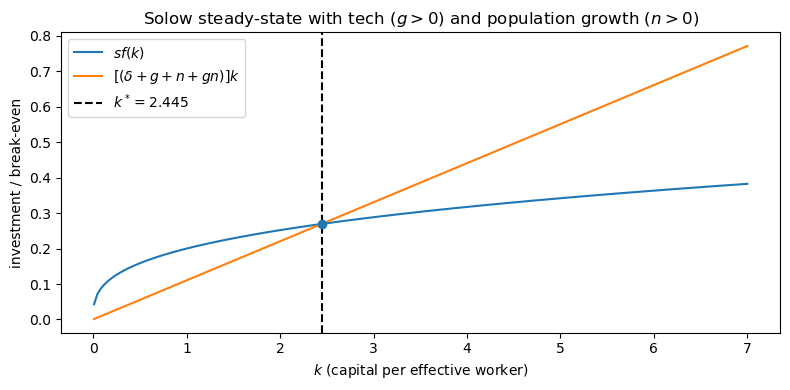

k* (g,n), alpha=0.33, s=0.20, delta=0.08, g=0.02 -> 2.44
k* (no growth), alpha=0.33, s=0.20, delta=0.08 -> 3.95


In [10]:
# It would make sense to create a plotting function, for readability and reusability purposes
# This could be an extension exercise for the students who finish early
# Also we could keep e.g. k_values as a global variable to avoid recreating it each time
# I opt for doing it here as well, to avoid using wrong parameters accidentally

# Code here is very similar to previous plotting code

# unpack parameters for easy use - keep in mind changing parameters will not update these variables automatically
alpha = parameters.alpha
s = parameters.s
delta = parameters.delta
g = parameters.g
n = parameters.n
gn = g*n

# create an array of k values for plotting
k_values = np.linspace(0.01, 7.0, 200)

# compute functions on plot
saving_values = s * f_ns(k_values,parameters)
break_down_values = (delta + g + n + gn) * k_values
steady_state_k = k_star_gn(parameters)


# plot the functions
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(1,1,1)
ax.plot(k_values, saving_values, label='$sf(k)$') # savings/blue line
ax.plot(k_values, break_down_values, label=r'$[(\delta + g + n + gn)]k$') # break-down/orange line
# using raw string ('r') for LaTeX formatting, so backslash('\') is not an escape character
ax.axvline(steady_state_k, color='black', linestyle='--', label=f'$k^*={steady_state_k:.3f}$') # line marking k*

# Cosmetics
ax.scatter(steady_state_k, s * f_ns(steady_state_k,parameters), zorder=10) # steady-state point
ax.set_xlabel('$k$ (capital per effective worker)')
ax.set_ylabel('investment / break-even')
ax.set_title('Solow steady-state with tech $(g>0)$ and population growth $(n>0)$')
ax.legend()
fig.tight_layout()
plt.show();

print(f'k* (g,n), alpha={alpha:.2f}, s={s:.2f}, delta={delta:.2f}, g={g:.2f} -> {steady_state_k:.2f}')
print(f'k* (no growth), alpha={alpha:.2f}, s={s:.2f}, delta={delta:.2f} -> {k_star_no_growth_ns(parameters):.2f}')

## 4. <a id='toc4_'></a>[Static steady-state comparison](#toc0_)

**Goal.** For a fixed parameter set, compare the Solow steady-state diagram **without growth**, **with technology growth** ($g>0$, $n=0$), and **with technology + population growth** ($g>0$, $n>0$).

**Do:**
1. Implement the three steady-state formulas  
   - no growth:  $k^*=\left(\dfrac{s}{\delta}\right)^{\tfrac{1}{1-\alpha}}$  
   - tech only:  $k^*=\left(\dfrac{s}{\delta+g}\right)^{\tfrac{1}{1-\alpha}}$  
   - tech+pop:   $k^*=\left(\dfrac{s}{(1+g)(1+n)-(1-\delta)}\right)^{\tfrac{1}{1-\alpha}}$  
2. In one figure with **three subplots**, draw for each case:  
   the curve $s f(k)$ with $f(k)=k^\alpha$, the relevant break-even line, and a dashed vertical line at $k^*$.
3. Use a **shared x-axis** across panels (pick a single $k_{\max}$ based on the largest $k^*$) so students can visually compare levels.

**Deliverable:** a single PNG or embedded figure with the three panels.


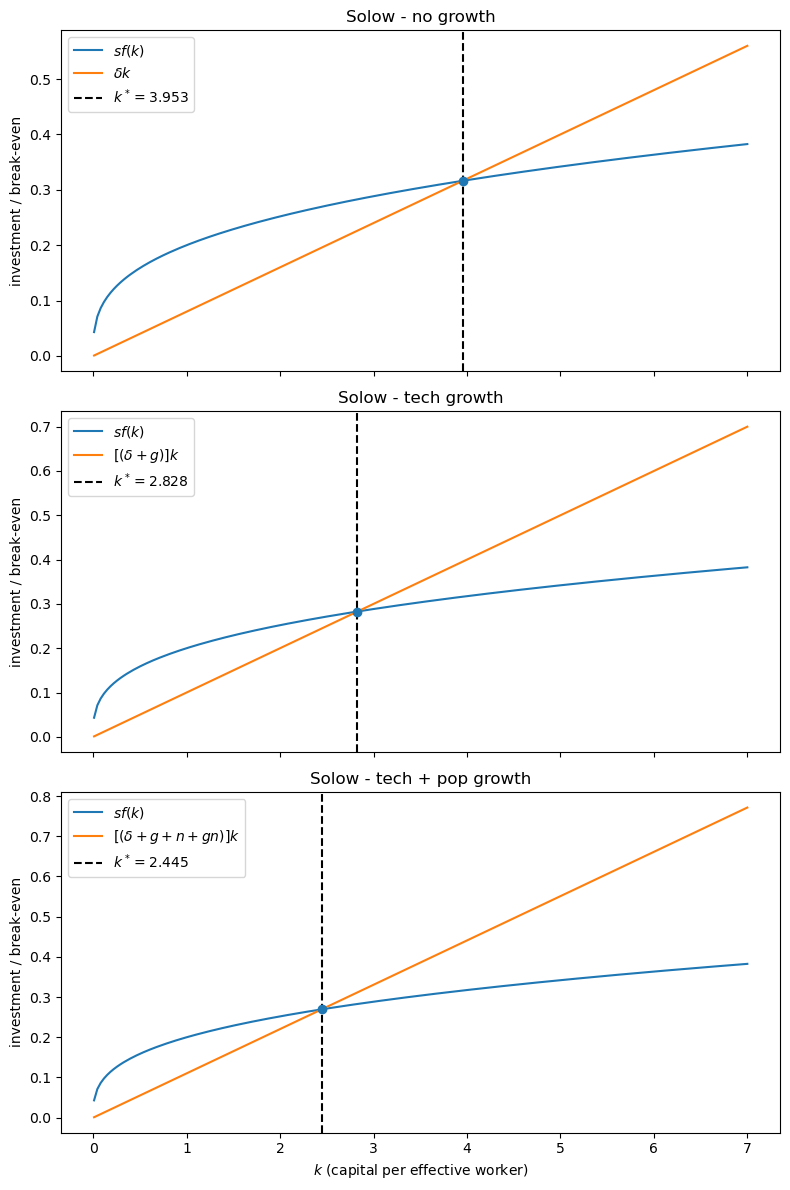

k* no growth = 3.95,  k* tech = 2.83, k* tech+pop = 2.44


In [11]:
# create an array of k values for plotting
k_values = np.linspace(0.01, 7.0, 200)

# compute functions on plot
saving_values = s * f_ns(k_values,parameters)
break_down_values_no_growth = (delta) * k_values
break_down_values_tech = (delta + g) * k_values
break_down_values_tech_and_pop = (delta + g + n + gn) * k_values
steady_state_k_no_growth = k_star_no_growth_ns(parameters)
steady_state_k_tech = k_star_with_g(parameters)
steady_state_k_tech_and_pop = k_star_gn(parameters)


# plot the functions
fig, ax = plt.subplots(3,1,figsize=(8,12), sharex=True) # sharex ensures same x-axis for all subplots(Do #3)

# plot no growth
ax[0].plot(k_values, saving_values, label='$sf(k)$') # savings/blue line
ax[0].plot(k_values, break_down_values_no_growth, label=r'$\delta k$') # break-down/orange line
ax[0].scatter(steady_state_k_no_growth, s * f_ns(steady_state_k_no_growth,parameters), zorder=10) # steady-state point
ax[0].axvline(steady_state_k_no_growth, color='black', linestyle='--', label=f'$k^*={steady_state_k_no_growth:.3f}$') # line marking k*

# plot tech growth only
ax[1].plot(k_values, saving_values, label='$sf(k)$') # savings/blue line
ax[1].plot(k_values, break_down_values_tech, label=r'$[(\delta + g)]k$') # break-down/orange line
ax[1].scatter(steady_state_k_tech, s * f_ns(steady_state_k_tech,parameters), zorder=10) # steady-state point
ax[1].axvline(steady_state_k_tech, color='black', linestyle='--',
              label=f'$k^*={steady_state_k_tech:.3f}$') # line marking k*

# plot tech and population growth
ax[2].plot(k_values, saving_values, label='$sf(k)$') # savings/blue line
ax[2].plot(k_values, break_down_values_tech_and_pop, label=r'$[(\delta + g + n + gn)]k$') # break-down/orange line
ax[2].scatter(steady_state_k_tech_and_pop, s * f_ns(steady_state_k_tech_and_pop,parameters), zorder=10) # steady-state point
ax[2].axvline(steady_state_k_tech_and_pop, color='black', linestyle='--',
              label=f'$k^*={steady_state_k_tech_and_pop:.3f}$') # line marking k*


# Cosmetics

# no growth
ax[0].set_ylabel('investment / break-even')
ax[0].set_title('Solow - no growth')
ax[0].legend()

# tech growth only
ax[1].set_ylabel('investment / break-even')
ax[1].set_title('Solow - tech growth')
ax[1].legend()

# tech and population growth
ax[2].set_xlabel('$k$ (capital per effective worker)')
ax[2].set_ylabel('investment / break-even')
ax[2].set_title('Solow - tech + pop growth')
ax[2].legend()


fig.tight_layout()
fig.savefig('Output&info\\solow-ss.png')
plt.show();

print(f'k* no growth = {steady_state_k_no_growth:.2f},  k* tech = {steady_state_k_tech:.2f},'
      f' k* tech+pop = {steady_state_k_tech_and_pop:.2f}')


_Note: Discuss the differences._


## 5. <a id='toc5_'></a>[Simulator with \(g\) and \(n\)](#toc0_)

Extend the lecture’s simulator to track levels $K_t, Y_t, A_t, L_t$, per worker, and per effective worker.

Assume exogenous sequences:
$
A_{t+1}=(1+g)A_t, \qquad L_{t+1}=(1+n)L_t.
$
Aggregate capital evolves as
$
K_{t+1} = s Y_t + (1-\delta)K_t, \qquad Y_t = K_t^{\alpha}(A_t L_t)^{1-\alpha}.
$


### 5.1. <a id='toc5_1_'></a>[Extend the Simulator](#toc0_)
Functions to implement:
- `simulate_solow(T, K0, A0, L0, alpha, s, delta, g, n)` - modify the function from the lecture to return a dict with arrays for `K, A, L, Y, k=K/(AL), y=Y/(AL), k_per_worker=K/L, y_per_worker=Y/L`.

Use the skeleton below as a starting point.


In [ ]:
# Changes are that we simulate for non-per effective worker variables K, A, L, Y, C
# Add the missing variables and equations for A and L growth
# If you want you could try to create the function using namespace or dictionary for parameters
# This would do away with the type requirements for the function arguments
# But those are also a bit excessive for the scope of this exercise

from typing import Callable, Union

ArrayLike = Union[float, np.ndarray, Callable[[int, float], float]]

def f(k: float, alpha: float) -> float:
    return k**alpha

def simulate_solow(
    K0: float,
    A0: float,
    L0: float,
    T: int,
    alpha: float = 1/3,
    s: ArrayLike = 0.20,
    delta: ArrayLike = 0.08,
    g: ArrayLike = 0.02,
    n: ArrayLike = 0.01,
):
    K = np.empty(T+1); A = np.empty(T+1); L = np.empty(T+1); Y = np.empty(T+1); C = np.empty(T+1)
    s_used = np.empty(T+1); d_used = np.empty(T+1); g_used = np.empty(T+1); n_used = np.empty(T+1)
    K[0], A[0], L[0] = float(K0), float(A0), float(L0)

    def val_at(x, t, k_t):
        if callable(x): return float(x(t, k_t))
        if np.ndim(x) == 0: return float(x)
        return float(x[t])

    for t in range(T):
        k_eff_t = K[t] / (A[t] * L[t])
        s_used[t] = val_at(s, t, k_eff_t)
        d_used[t] = val_at(delta, t, k_eff_t)
        g_used[t] = val_at(g, t, k_eff_t)
        n_used[t] = val_at(n, t, k_eff_t)

        Y[t] = (K[t]**alpha) * (A[t]*L[t])**(1 - alpha)
        C[t] = (1.0 - s_used[t]) * Y[t]

        K[t+1] = s_used[t] * Y[t] + (1.0 - d_used[t]) * K[t]
        A[t+1] = (1.0 + g_used[t]) * A[t]
        L[t+1] = (1.0 + n_used[t]) * L[t]

    # Last-period accounting
    k_eff_T = K[-1] / (A[-1] * L[-1])
    s_used[-1] = val_at(s, T, k_eff_T)
    d_used[-1] = val_at(delta, T, k_eff_T)
    g_used[-1] = val_at(g, T, k_eff_T)
    n_used[-1] = val_at(n, T, k_eff_T)

    Y[-1] = (K[-1]**alpha) * (A[-1]*L[-1])**(1 - alpha)
    C[-1] = (1.0 - s_used[-1]) * Y[-1]

    # get effective series out
    k_eff = K / (A * L)
    y_eff = Y / (A * L)
    k_per_worker  = K / L
    y_per_worker  = Y / L
    

    return {
        "K": K, "A": A, "L": L, "Y": Y, "C": C,
        "k_eff": k_eff, "y_eff": y_eff, "k_per_worker": k_per_worker, "y_per_worker": y_per_worker,
        "s_path": s_used, "delta_path": d_used, "g_path": g_used, "n_path": n_used,
    }



### 5.2. <a id='toc5_2_'></a>[Halving population growth under $g>0$](#toc0_)

**Goal.** With your growth‐enabled simulator, study a case where population growth **halves** at time $t_{\text{switch}}$ and plot transitions of **capital per effective worker** $k_t$ and **consumption per effective worker** $c_t$.

**Do:**
1. Build $n_t$ of length $T{+}1$: $n_t=n_0$ for $t<t_{\text{switch}}$, $n_t=\tfrac{1}{2}n_0$ for $t\ge t_{\text{switch}}$.
2. Run **baseline** with constant $n_0$ and the **case** with your $n_t$; keep $g>0$ fixed and all other params identical.
3. From each run compute $k_t=K_t/(A_tL_t)$ and $c_t=C_t/(A_tL_t)$, where $C_t=(1-s_t)Y_t$.
4. Plot two lines (baseline vs. scenario) for $k_t$ and for $c_t$; add a vertical dashed line at $t_{\text{switch}}$.

**Hints (relative to version without $g,n$):**
- Update **levels** each step: $K_{t+1}=s_tY_t+(1-\delta_t)K_t$, $A_{t+1}=(1+g_t)A_t$, $L_{t+1}=(1+n_t)L_t$, $Y_t=K_t^\alpha(A_tL_t)^{1-\alpha}$.
- Then form per-effective-worker variables by dividing by $A_tL_t$.
- Ensure arrays are length $T{+}1$ and compute $Y_T,C_T$ at the end.

**Deliverables:** Two figures ($k_t$ and $c_t$ per effective worker) comparing baseline vs. halved $n$, clearly marking $t_{\text{switch}}$.


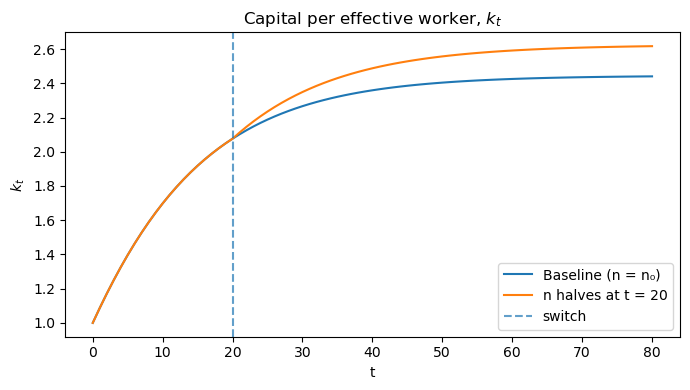

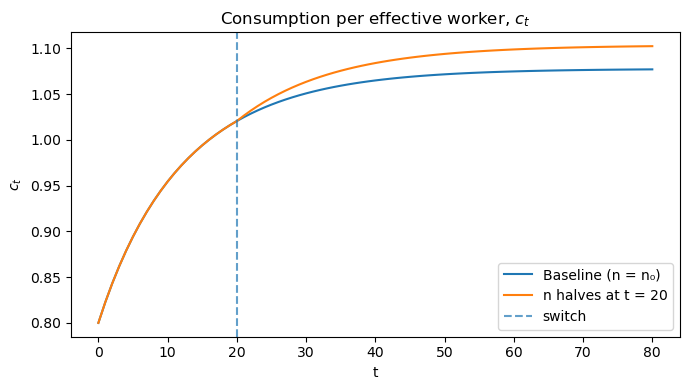

In [16]:
# set path length, switch time and starting parameters
T = 80
t_switch = 20
n0 = 0.01
K0 = 1.0; A0 = 1.0; L0 = 1.0

# and baseline parameters
alpha   = 1/3
s       = 0.20
delta   = 0.08
g       = 0.02

# make path
n_path = np.full(T+1, n0, dtype=float)
if 0 <= t_switch <= T:
    n_path[t_switch:] = 0.5 * n0
    
# simulate baseline model
baseline = simulate_solow(
    K0=K0, A0=A0, L0=L0, T=T,
    alpha=alpha, s=s, delta=delta,
    g=g, n=n0
)

# simulate model with population growth change
pop_halves = simulate_solow(
    K0=K0, A0=A0, L0=L0, T=T,
    alpha=alpha, s=s, delta=delta,
    g=g, n=n_path
)


# Here I plot using solutions from both simulations and code from A5_2

# Per-effective-worker series
k_base  = baseline["k_eff"]
k_half  = pop_halves["k_eff"]
c_base  = baseline["C"] / (baseline["A"] * baseline["L"])
c_half  = pop_halves["C"] / (pop_halves["A"] * pop_halves["L"])

# ------------------ Plots ------------------
tgrid = np.arange(T+1)

# (1) Capital per effective worker
plt.figure(figsize=(7,4))
plt.plot(tgrid, k_base,  label="Baseline (n = n₀)")
plt.plot(tgrid, k_half,  label="n halves at t = {}".format(t_switch))
plt.axvline(t_switch, linestyle="--", alpha=0.7, label="switch")
plt.title("Capital per effective worker, $k_t$")
plt.xlabel("t")
plt.ylabel("$k_t$")
plt.legend(loc="best")
plt.tight_layout()
plt.show()

# (2) Consumption per effective worker
plt.figure(figsize=(7,4))
plt.plot(tgrid, c_base, label="Baseline (n = n₀)")
plt.plot(tgrid, c_half, label="n halves at t = {}".format(t_switch))
plt.axvline(t_switch, linestyle="--", alpha=0.7, label="switch")
plt.title("Consumption per effective worker, $c_t$")
plt.xlabel("t")
plt.ylabel("$c_t$")
plt.legend(loc="best")
plt.tight_layout()
plt.show()

### 5.3. <a id='toc5_3_'></a>[Savings rate rises by 20%](#toc0_)

**Goal.** Use your growth-adjusted simulator to study a **permanent 20% increase** in the savings rate at time $t_{\text{switch}}$. Compare **capital per effective worker** $k_t$ and **consumption per effective worker** $c_t$ to a baseline with constant $s$.

**Do:**
1. Build an $s_t$ path (length $T{+}1$): $s_t=s_0$ for $t<t_{\text{switch}}$, $s_t=1.2\,s_0$ for $t\ge t_{\text{switch}}$ (clip so $s_t<1$).
2. Run two simulations with identical $(\alpha,\delta,g,n)$ and initial $(K_0,A_0,L_0)$:
   - **Baseline:** constant $s_0$.
   - **Policy:** piecewise $s_t$ from step 1.
3. Compute $k_t = K_t/(A_t L_t)$ and $c_t = C_t/(A_t L_t)$ for both runs.
4. Plot transitions (two lines each) and mark $t_{\text{switch}}$ with a dashed vertical line.

**Hints:** Reuse your simulator’s flexibility for time-varying arrays; ensure arrays are length $T{+}1$ and compute $Y_T,C_T$ at the end as in the baseline version.


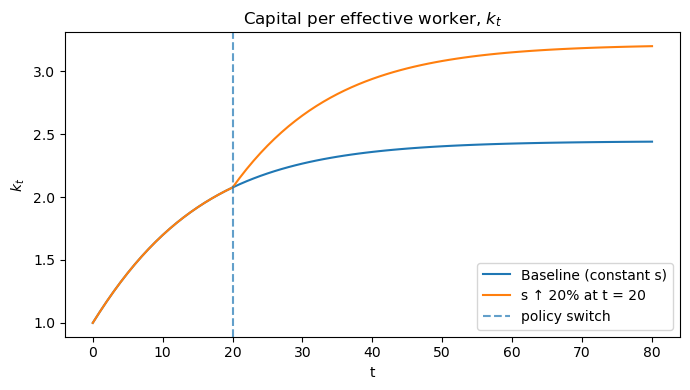

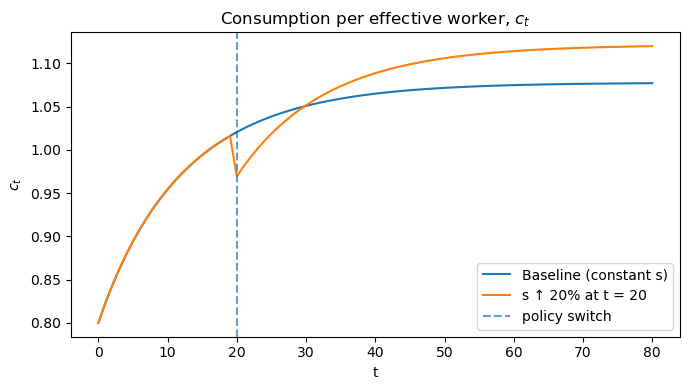

In [17]:
# set starting savings rate
s0 = 0.20

# make path
s_path = np.full(T+1, s0, dtype=float)
if 0 <= t_switch <= T:
    s_path[t_switch:] = 1.2 * s0
    
# simulate model with savings rate change
savings_increase = simulate_solow(
    K0=K0, A0=A0, L0=L0, T=T,
    alpha=alpha, s=s_path, delta=delta,
    g=g, n=n0
)

# plot using solution in A5_3

# ------------------ Series per effective worker -------------------
tgrid   = np.arange(T+1)
k_base  = baseline["k_eff"]
k_pol   = savings_increase["k_eff"]
c_base  = baseline["C"] / (baseline["A"] * baseline["L"])
c_pol   = savings_increase["C"] / (savings_increase["A"] * savings_increase["L"])

# ------------------ Plots -----------------------------------------
# (1) Capital per effective worker
plt.figure(figsize=(7,4))
plt.plot(tgrid, k_base, label="Baseline (constant s)")
plt.plot(tgrid, k_pol,  label="s ↑ 20% at t = {}".format(t_switch))
plt.axvline(t_switch, linestyle="--", alpha=0.7, label="policy switch")
plt.title("Capital per effective worker, $k_t$")
plt.xlabel("t")
plt.ylabel("$k_t$")
plt.legend(loc="best")
plt.tight_layout()
plt.show()

# (2) Consumption per effective worker
plt.figure(figsize=(7,4))
plt.plot(tgrid, c_base, label="Baseline (constant s)")
plt.plot(tgrid, c_pol,  label="s ↑ 20% at t = {}".format(t_switch))
plt.axvline(t_switch, linestyle="--", alpha=0.7, label="policy switch")
plt.title("Consumption per effective worker, $c_t$")
plt.xlabel("t")
plt.ylabel("$c_t$")
plt.legend(loc="best")
plt.tight_layout()
plt.show() 